<a href="https://colab.research.google.com/github/ms1901/CF_Project/blob/main/Analysis/Analysis_CARL_GoodReads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow

In [ ]:
import numpy as np
import scipy.sparse as sp
import math

import tensorflow as tf
import numpy as np
import sys
from time import time
import os

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
%cd /content/drive/MyDrive/CF_end_proejct/Goodreads

/content/drive/MyDrive/CF_end_proejct/Goodreads


In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


ExtractData

In [ ]:
class Dataset(object):
    "'extract dataset from file'"

    def __init__(self, max_length, path, word_id_path):
        self.word_id_dict = self.load_word_dict(path + word_id_path)
        print("wordId_dict finished")
        
        self.userReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingUserReviews.out")
        self.itemReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingItemReviews.out")
        print("load reviews finished")
        
        self.num_users, self.num_items = len(self.userReview_dict), len(self.itemReview_dict)
        
        self.trainMtrx = self.load_ratingFile_as_mtrx(path + "dataPreprocessingTrainInteraction.out")
        self.valRatings = self.load_ratingFile_as_list(path + "dataPreprocessingValInteraction.out")
        self.testRatings = self.load_ratingFile_as_list(path + "dataPreprocessingTestInteraction.out")

    def load_word_dict(self, path):
        wordId_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                arr = line.split("\t")
                wordId_dict[arr[0]] = int(arr[1])
                line = f.readline().replace("\n", "")

        return wordId_dict

    def load_reviews(self, max_doc_length, padding_word_id, path):
        entity_review_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                review = []
                arr = line.split("\t")
                entity = int(arr[0])
                word_list = arr[1].split(" ")

                for i in range(len(word_list)):
                    if (word_list[i] == "" or word_list[i] == None or (not self.word_id_dict[word_list[i]] in self.word_id_dict.keys())):
                        continue
                    review.append(self.word_id_dict.get(word_list[i]))
                    if (len(review) >= max_doc_length):
                        break
                if (len(review) < max_doc_length):
                    review = self.padding_word(max_doc_length, padding_word_id, review)
                entity_review_dict[entity] = review
                line = f.readline().replace("\n", "")
        return entity_review_dict

    def padding_word(self, max_size, max_word_idx, review):
        review.extend([max_word_idx]*(max_size - len(review)))
        return review

    def load_ratingFile_as_mtrx(self, file_path):
        mtrx = sp.dok_matrix((self.num_users, self.num_items), dtype=np.float32)
        with open(file_path, "r") as f:
            line = f.readline()
            line = line.strip()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mtrx[user, item] = rating
                line = f.readline()

        return mtrx

    def load_ratingFile_as_list(self, file_path):
        rateList = []

        with open(file_path, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                rate = float(arr[2])
                rateList.append([user, item, rate])
                line = f.readline()

        return rateList

GetTest

In [ ]:
import math

def get_test_list(batch_size, test_rating, user_reviews, item_reviews):
    user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs = [], [], [], [], []
    for count in range(int(math.ceil(len(test_rating) / float(batch_size)))):
        user_test, item_test, user_input_test, item_input_test, rating_input_test = [], [], [], [], []
        for idx in range(batch_size):
            index = (count * batch_size + idx)
            if (index >= len(test_rating)):
                break
            rating = test_rating[index]
            user_test.append(rating[0])
            item_test.append(rating[1])
            user_input_test.append(user_reviews.get(rating[0]))
            item_input_test.append(item_reviews.get(rating[1]))
            rating_input_test.append([rating[2]])
        user_test_batchs.append(user_test)
        item_test_batchs.append(item_test)
        user_input_test_batchs.append(user_input_test)
        item_input_test_batchs.append(item_input_test)
        rating_input_test_batchs.append(rating_input_test)
        #print count, len(item_input_test_batchs[count])
    return user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs

CARL

In [ ]:
def ini_word_embed(num_words, latent_dim):
    word_embeds = np.random.rand(num_words, latent_dim)
    return word_embeds


In [ ]:
def word2vec_word_embed(num_words, latent_dim, path, word_id_dict):
    word2vect_embed_mtrx = np.zeros((num_words, latent_dim))
    with open(path, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            row_id = word_id_dict.get(arr[0])
            vect = arr[1].strip().split(" ")
            for i in range(len(vect)):
                word2vect_embed_mtrx[row_id, i] = float(vect[i])
            line = f.readline()

    return word2vect_embed_mtrx

In [ ]:
def get_train_instance(train):
    user_input, item_input, rates = [], [], []

    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        rates.append(train[u,i])
    return user_input, item_input, rates



In [ ]:
def get_train_instance_batch_change(count, batch_size, user_input, item_input, ratings, user_reviews, item_reviews):
    users_batch, items_batch, user_input_batch, item_input_batch, labels_batch = [], [], [], [], []

    for idx in range(batch_size):
        index = (count*batch_size + idx) % len(user_input)
        users_batch.append(user_input[index])
        items_batch.append(item_input[index])
        user_input_batch.append(user_reviews.get(user_input[index]))
        item_input_batch.append(item_reviews.get(item_input[index]))
        labels_batch.append([ratings[index]])

    return users_batch, items_batch, user_input_batch, item_input_batch, labels_batch

In [ ]:
#review.py
def  cnn_model_average(filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix):
    #convolution layer
    convU = tf.nn.conv2d(user_reviews_representation_expnd, W_u, strides=[1, 1, word_latent_dim, 1], padding='SAME')
    convI = tf.nn.conv2d(item_reviews_representation_expnd, W_i, strides=[1, 1, word_latent_dim, 1], padding='SAME')

    hU = tf.nn.relu(tf.squeeze(convU, 2))
    hI = tf.nn.relu(tf.squeeze(convI, 2))

    # attentive layer
    sec_dim = int(hU.get_shape()[1])
    tmphU = tf.reshape(hU, [-1, filters])
    hU_mul_rand = tf.reshape(tf.matmul(tmphU, rand_matrix), [-1, sec_dim, filters])
    f = tf.matmul(hU_mul_rand, hI, transpose_b=True)
    f = tf.expand_dims(f, -1)
    att1 = tf.tanh(f)

    pool_user = tf.reduce_mean(att1, 2)
    pool_item = tf.reduce_mean(att1, 1)

    user_flat = tf.squeeze(pool_user, -1)
    item_flat = tf.squeeze(pool_item, -1)

    weight_user = tf.nn.softmax(user_flat)
    weight_item = tf.nn.softmax(item_flat)

    weight_user_exp = tf.expand_dims(weight_user, -1)
    weight_item_exp = tf.expand_dims(weight_item, -1)

    hU = tf.expand_dims(hU * weight_user_exp, -1)
    hI = tf.expand_dims(hI * weight_item_exp, -1)

    #abstracting layer
    hU_1 = tf.nn.relu(tf.nn.conv2d(hU, W_u_1, strides=[1, 1, 1, 1], padding='VALID'))
    hI_1 = tf.nn.relu(tf.nn.conv2d(hI, W_i_1, strides=[1, 1, 1, 1], padding='VALID'))

    sec_dim = hU_1.get_shape()[1]

    oU = tf.nn.avg_pool(hU_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')
    oI = tf.nn.avg_pool(hI_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')

    att_user = tf.squeeze(oU)
    att_item = tf.squeeze(oI)
    #print "attention", att_user.get_shape(), att_item.get_shape()

    return att_user, att_item

In [ ]:
def eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_batch, item_batch, user_input_batch, item_input_batch, rate_tests, rmses, maes):
    print(sess)
    print("user batch. "+str(user_batch))
    print("item batch "+str(item_batch))
    print("user_input_batch. "+str(user_input_batch))
    print("item_input_batch "+str( item_input_batch))

    print("before session run")
    predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
    print("after session run")
    #print(predicts)
    row, col = predicts.shape
    for r in range(row):
        rmses.append(pow((predicts[r, 0] - rate_tests[r][0]), 2))
        maes.append(abs((predicts[r, 0] - rate_tests[r][0])))
    print(rmses)
    return rmses, maes


## Just interaction based

In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    # w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    # w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    # v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    # J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    # embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    # embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    # J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    # J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    # numerator = J_total + J_e_total
    numerator = J_e_total
    # predict_rating = tf.divide(J_total, numerator) * J_total + tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs
    predict_rating = tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs 
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v_entity) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.05 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 180
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 2.044s
506 2581
15
shape (19930, 300)
18880 18880 18880
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 3.969s test time: 0.456  loss = 199.018 val_mse = 15.116 mse = 15.267 mae = 3.719
epoch1 train time: 2.377s test time: 0.452  loss = 132.983 val_mse = 13.845 mse = 14.038 mae = 3.559
epoch2 train time: 2.507s test time: 0.499  loss = 70.851 val_mse = 12.473 mse = 12.710 mae = 3.375
epoch3 train time: 2.412s test time: 0.483  loss = 36.328 val_mse = 10.469 mse = 10.794 mae = 3.069
epoch4 train time: 2.478s test time: 0.561  loss = 18.892 val_mse = 7.892 mse = 8.399 mae = 2.606
epoch5 train time: 2.401s test time: 0.499  loss = 11.255 val_mse = 5.982 mse = 6.626 mae = 2.230
epoch6 train time: 2.151s test time: 0.381  loss = 8.543 val_mse = 4.777 mse = 5.485 mae = 1.987
epoch7 train time: 2.085s test time: 0.518  loss = 7.537 val_mse = 4.014 mse

## Just review based

In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    # user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    # item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    # user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    # item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    # entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    # w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    # w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    # v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    # J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    # entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    # entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    # J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    # J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    # numerator = J_total + J_e_total
    numerator = J_total
    # predict_rating = tf.divide(J_total, numerator) * J_total + tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs 
    predict_rating = tf.divide(J_total, numerator) * J_total + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.05 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 180
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 4.912s
506 2581
15
shape (19930, 300)
18880 18880 18880
epoch0 train time: 17.480s test time: 0.963  loss = 187.961 val_mse = 1.575 mse = 1.510 mae = 0.880
epoch1 train time: 9.013s test time: 0.894  loss = 119.428 val_mse = 1.586 mse = 1.520 mae = 0.882
epoch2 train time: 8.972s test time: 0.902  loss = 58.817 val_mse = 1.586 mse = 1.520 mae = 0.882
epoch3 train time: 9.008s test time: 0.889  loss = 25.554 val_mse = 1.586 mse = 1.520 mae = 0.882
epoch4 train time: 8.973s test time: 0.892  loss = 9.639 val_mse = 1.584 mse = 1.519 mae = 0.882
epoch5 train time: 9.001s test time: 0.906  loss = 3.448 val_mse = 1.583 mse = 1.517 mae = 0.882
epoch6 train time: 8.997s test time: 0.914  loss = 1.797 val_mse = 1.581 mse = 1.516 mae = 0.881
epoch7 train time: 9.011s test time: 0.903  loss = 1.562 val_mse = 1.579 mse = 1.514 mae = 0.880
epoch8 train time: 9.082s test time: 1.029  loss = 1.486 val_mse = 1.576 mse = 1.512 mae = 0.880
epoch9 tr

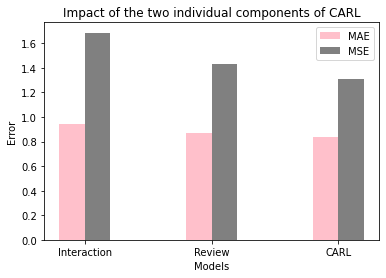

In [ ]:
mae_list = [0.9416255216488819, 0.8700475400953301, 0.8339613501772636]
mse_list = [1.6866763914333192, 1.434916430121106, 1.3063634430115583]
models = ['Interaction','Review', 'CARL']
X_axis = np.arange(len(models))
plt.bar(X_axis - 0.1, mae_list, 0.2, label = 'MAE', color='pink')
plt.bar(X_axis + 0.1, mse_list, 0.2, label = 'MSE', color='grey')
plt.title('Impact of the two individual components of CARL')
plt.xticks(X_axis, models)
plt.xlabel('Models')
plt.ylabel('Error')
plt.legend()
plt.show()

dynamic linear fusion vs varying alpha 

alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0,6, 0.7, 0.8, 0.9, 1]


In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    alpha = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    # numerator = J_total + J_e_total
    predict_rating = alpha * J_total + (1 - alpha) * J_e_total + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v) + tf.nn.l2_loss(v_entity) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out, alpha: a})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out, alpha: a})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out, alpha: a})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 5
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.6
    batch_size = 300
    epochs = 120
    a_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0,6, 0.7, 0.8, 0.9, 1]
    a = 0.1
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    # train_model()

    # a = 0.2
    # #train & eval model
    # train_model()

    # a = 0.3
    # #train & eval model
    # train_model()

    # a = 0.4
    # #train & eval model
    # train_model()

    # a = 0.5
    # #train & eval model
    # train_model()

    # a = 0.6
    # #train & eval model
    # train_model()

    a = 0.7
    #train & eval model
    train_model()

    a = 0.8
    #train & eval model
    train_model()

    a = 0.9
    #train & eval model
    train_model()

    a = 1
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 1.568s
506 2581
15
shape (19930, 300)
18880 18880 18880
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 22.163s test time: 0.970  loss = 73.102 val_mse = 2.917 mse = 2.923 mae = 1.529
epoch1 train time: 5.916s test time: 0.748  loss = 60.798 val_mse = 1.546 mse = 1.491 mae = 0.930
epoch2 train time: 5.999s test time: 0.765  loss = 44.603 val_mse = 1.542 mse = 1.487 mae = 0.928
epoch3 train time: 6.234s test time: 0.760  loss = 28.812 val_mse = 1.539 mse = 1.484 mae = 0.925
epoch4 train time: 6.052s test time: 0.769  loss = 17.841 val_mse = 1.535 mse = 1.481 mae = 0.924
epoch5 train time: 6.101s test time: 0.772  loss = 10.598 val_mse = 1.530 mse = 1.477 mae = 0.923
epoch6 train time: 6.334s test time: 0.884  loss = 6.093 val_mse = 1.525 mse = 1.473 mae = 0.921
epoch7 train time: 6.203s test time: 0.784  loss = 3.500 val_mse = 1.519 mse = 1.469 

## Plot

avg mae over alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: [0.8750364511057321, 0.863824053714779, 0.8592177252143982, 0.8527685427680036, 0.8538870170462247, 0.860016459557814, 0.8611507236816345, 0.8678378841134752, 0.8887613208692435, 0.8978200408157662]
avg mse over alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: [1.4467357106160585, 1.3971177984800593, 1.376702370229998, 1.3462015648002874, 1.3396905775303876, 1.3510617804467742, 1.34180853475892, 1.353348614027472, 1.3927576118486096, 1.419021158007399]


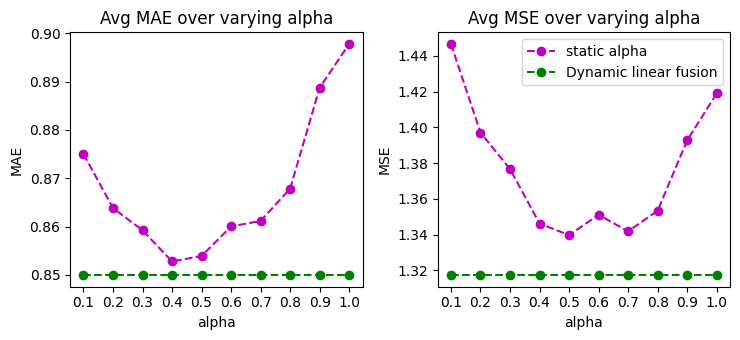

minimum avg mae over alphas = 0.8527685427680036 at alpha = 0.4 and mse = 1.3462015648002874
minimum avg mse over alphas = 1.3396905775303876 at alpha = 0.5 and mae = 0.8538870170462247


In [ ]:
avg_mae_list = [0.8750364511057321,0.863824053714779,0.8592177252143982,0.8527685427680036,0.8538870170462247,0.860016459557814,0.8611507236816345,0.8678378841134752,0.8887613208692435,0.8978200408157662]
avg_mse_list = [1.4467357106160585,1.3971177984800593,1.376702370229998,1.3462015648002874,1.3396905775303876,1.3510617804467742,1.34180853475892,1.353348614027472,1.3927576118486096,1.419021158007399]
mae_dlf = [0.8499268625805789]*10
mse_dlf = [1.317287691183217]*10
a_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
print(f'avg mae over alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: {avg_mae_list}')
print(f'avg mse over alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(a_list, avg_mae_list, 'm--o', label = 'static alpha')
axes[0].plot(a_list, mae_dlf, 'g--o', label = 'Dynamic linear fusion')
axes[0].set_title('Avg MAE over varying alpha')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('MAE')
axes[0].set_xticks(a_list)

axes[1].plot(a_list, avg_mse_list, 'm--o', label = 'static alpha')
axes[1].plot(a_list, mse_dlf, 'g--o', label = 'Dynamic linear fusion')
axes[1].set_title('Avg MSE over varying alpha')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('MSE')
axes[1].set_xticks(a_list)
plt.tight_layout()
plt.legend()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over alphas = {min} at alpha = {a_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over alphas = {min} at alpha = {a_list[min_index]} and mae = {avg_mae_list[min_index]}')

## Without the FM

In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    # w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    # w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    # v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    # #I---
    # w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    # w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    # v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    # #I---
    # J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    # #R---
    # J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    # #I---
    # entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    # entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    # #R---
    # embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    # embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    # #I---
    # J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    # #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    # #R---
    # J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    # #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    # #R---
    # J_total = (J_1 + 0.5 * (J_2))
    
    # #I---
    # J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    numerator = embeds_sum + entity_embeds_sum
    predict_rating = tf.divide(embeds_sum, numerator) * embeds_sum + tf.divide(entity_embeds_sum, numerator) * entity_embeds_sum + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.05 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.6
    batch_size = 200
    epochs = 180
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 4.158s
506 2581
15
shape (19930, 300)
18880 18880 18880
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 21.025s test time: 0.963  loss = 195.459 val_mse = 15.981 mse = 16.114 mae = 3.826
epoch1 train time: 9.202s test time: 0.895  loss = 131.111 val_mse = 15.615 mse = 15.748 mae = 3.780
epoch2 train time: 9.419s test time: 0.899  loss = 70.698 val_mse = 15.109 mse = 15.240 mae = 3.716
epoch3 train time: 9.263s test time: 0.905  loss = 37.313 val_mse = 14.472 mse = 14.602 mae = 3.634
epoch4 train time: 9.312s test time: 0.896  loss = 21.022 val_mse = 13.718 mse = 13.847 mae = 3.533
epoch5 train time: 9.281s test time: 0.919  loss = 14.318 val_mse = 12.861 mse = 12.988 mae = 3.416
epoch6 train time: 9.478s test time: 0.900  loss = 12.056 val_mse = 11.916 mse = 12.040 mae = 3.281
epoch7 train time: 9.274s test time: 0.906  loss = 11.150 val_mse = 

In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    # w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    # w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    # v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    # #I---
    # w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    # w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    # v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    # #I---
    # J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    # #R---
    # J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    # #I---
    # entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    # entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    # #R---
    # embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    # embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    # #I---
    # J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    # #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    # #R---
    # J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    # #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    # #R---
    # J_total = (J_1 + 0.5 * (J_2))
    
    # #I---
    # J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    numerator = embeds_sum + entity_embeds_sum
    predict_rating = tf.divide(embeds_sum, numerator) * embeds_sum + tf.divide(entity_embeds_sum, numerator) * entity_embeds_sum + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))